In [1]:
import keras
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import Recall, Precision
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 128
BATCH_SIZE = 32

train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train = train_val_datagen.flow_from_directory(
    '/kaggle/input/dogs-vs-cats/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=42,
)
val = train_val_datagen.flow_from_directory(
    '/kaggle/input/dogs-vs-cats/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=42,
)
test = test_datagen.flow_from_directory(
    '/kaggle/input/dogs-vs-cats/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
train.class_indices

{'cats': 0, 'dogs': 1}

In [3]:
y_true = np.concatenate([test[idx][1] for idx in range(len(test))], axis=0)
y_true

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [6]:
def callbacks(model_name):
  CallBacks = []

  best_model = ModelCheckpoint(filepath=f'{model_name}.keras',monitor='val_loss',save_best_only=True)
  CallBacks.append(best_model)

  early_stop = EarlyStopping(monitor='val_loss',patience=7)
  CallBacks.append(early_stop)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=0.00001)
  CallBacks.append(reduce_lr)

  return CallBacks

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

LOSS = BinaryCrossentropy(from_logits=False)
optimizer = Adam(learning_rate=0.001)
SEED = 7

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation="sigmoid")
])

In [8]:
model.compile(
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy',Recall(),Precision()]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,517,185 (24.86 MB)

 Trainable params: 6,516,737 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
call_backs = callbacks('CNN')
model.fit(train,epochs=200,validation_data=val,callbacks=call_backs)

Epoch 1/200


I0000 00:00:1746983134.175218     114 service.cc:148] XLA service 0x7cd360004980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746983134.176845     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746983134.176870     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746983134.772436     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:50:16 13s/step - accuracy: 0.4688 - loss: 1.6136 - precision: 0.6000 - recall: 0.4500

I0000 00:00:1746983141.163431     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 148s 270ms/step - accuracy: 0.5928 - loss: 1.7319 - precision: 0.6117 - recall: 0.5517 - val_accuracy: 0.6712 - val_loss: 0.6922 - val_precision: 0.7617 - val_recall: 0.4985 - learning_rate: 0.0010
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.7018 - loss: 0.5672 - precision: 0.7489 - recall: 0.6143 - val_accuracy: 0.6367 - val_loss: 0.6962 - val_precision: 0.8924 - val_recall: 0.3110 - learning_rate: 0.0010
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 96ms/step - accuracy: 0.7449 - loss: 0.5197 - precision: 0.7703 - recall: 0.6892 - val_accuracy: 0.7188 - val_loss: 0.5267 - val_precision: 0.8145 - val_recall: 0.5665 - learning_rate: 0.0010
Epoch 4/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - accuracy: 0.7809 - loss: 0.4649 - precision: 0.8022 - recall: 0.7440 - val_accuracy: 0.7253 - val_loss: 0.5720 - val_precision: 0.8375 - val_recall: 0.5590 - learning_rate: 0.0010
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - accur

In [10]:
best_model = tf.keras.models.load_model('CNN.keras')
best_model.evaluate(test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.9100 - loss: 0.2564 - precision: 0.3955 - recall: 0.4285


[0.3218270540237427, 0.8849999904632568, 0.8471999764442444, 0.916486382484436]

In [11]:
y_pred = best_model.predict(test)
y_pred

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


array([[2.7539750e-07],
       [1.2031433e-03],
       [4.2038704e-03],
       ...,
       [9.8963737e-01],
       [9.5830518e-01],
       [6.6334528e-01]], dtype=float32)

In [12]:
y_pred = np.round(y_pred)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89      2500
         1.0       0.92      0.85      0.88      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.88      5000
weighted avg       0.89      0.89      0.88      5000



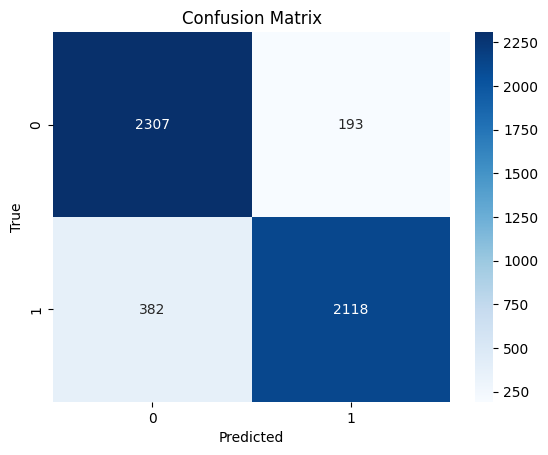

In [13]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()